# Random Forests 5

---

__This Notebook__

Evaluates the results of the previous notebook's grid search and conducts another grid search with slightly deeper parameters.


__Results__ 

The two best representations are very similar, the variance in models make the top one switch back and forth depending on the run. Curiously, the deeper parameters aren't necessarily yielding much better results, which means we're probably arriving at our top mean validation sensitivity around 94%. 

__Next Notebook__

It'd be interesting to look at grid search results insofar as training times and variance of the models, and then pick one to move the decision threshold so as to yield the most appropriate balance between sensitivity and specificity, given that we believe sensitivity to be more desirable.


---

## Setup & Load Results

The are the results of the grid searches in the previous 3 notebooks (__12_RandomForests3.1__, __3.2__, and __3.3__).

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp

import custom.new_gridsearch as ng

from datetime import datetime

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-12


In [2]:
# load grid searches
mod_path = os.path.join("data","3_modeling")
filename = '01092021_rf_gridsearches.joblib'
                
gridsearches = joblib.load(os.path.join(mod_path, filename))

In [3]:
def extract_df(dic):
    df = pd.concat([
                    pd.DataFrame({'representation':[dic['representation']] \
                                * len(dic['gridsearch_res'].cv_results_["params"])}),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["params"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_acc"], 
                                 columns=["mean_val_acc"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tpr"], 
                                 columns=["mean_val_tpr"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tnr"], 
                                 columns=["mean_val_tnr"])
                    ], axis=1)
    return df

# create list of dfs
df_list = []
for ix, dic in enumerate(gridsearches):
    df_list.append(extract_df(dic))

# flatten and reindex
dfm = pd.concat(df_list)
dfm.index = range(len(dfm))

# sort by top mean validation sensitivity
top_tpr = dfm.sort_values(by=['mean_val_tpr'], ascending=False).iloc[:4,:].copy()
top_tpr

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr
67,X_bot_cossim_bot,20,500,5,200,0.991110,0.943320,0.998421
23,X_bot_cossim_bot,5,500,15,200,0.990766,0.943252,0.998027
21,X_bot_cossim_bot,5,500,10,200,0.990766,0.943252,0.998027
66,X_bot_cossim_bot,20,500,5,100,0.990767,0.940688,0.998421


In [4]:
dfm[dfm['representation']=='X_tfidf_cossim_tfidf'].sort_values(by=['mean_val_tpr'], ascending=False).iloc[:4,:]

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr
135,X_tfidf_cossim_tfidf,20,250,10,200,0.986319,0.919973,0.99645
143,X_tfidf_cossim_tfidf,20,500,15,200,0.985976,0.917409,0.99645
90,X_tfidf_cossim_tfidf,5,500,5,100,0.985976,0.917409,0.99645
112,X_tfidf_cossim_tfidf,10,250,15,100,0.985976,0.917409,0.99645


Curiously, the 10-fold cross validation mean sensitivity is lower for the tfidf than for the bot, which is the opposite of what I expected after running the single confusion matrices in the previous notebook. This reversal might be due to the variance in the model, something to be tested. 

First, I run a slightly more involved grid search with these models using more trees and greater depth.

In [5]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

y = y_train.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

In [6]:
import custom.clean_preprocess as cp

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([('counter', cp.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bot', cp.WordCounterToVectorTransformer(vocabulary_size=2000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True))
                ])

X_counter = pipe['counter'].fit_transform(X_train)
X_bot = pipe['bot'].fit_transform(X_counter)
X_tfidf = pipe.fit_transform(X_train)

In [7]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

def perform_SVD(X, n_components=300):
    
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, # term-document matrix
                        k=n_components)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    
    # return V 
    V = VT.T
    return V # do not scale for random forests!

X_svd_bot = perform_SVD(X_bot)
X_svd_tfidf = perform_SVD(X_tfidf)

In [8]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

X_cossim_svd_bot = cosine_similarity(X_svd_bot)
X_cossim_svd_tfidf = cosine_similarity(X_svd_tfidf)

train_df = pd.DataFrame({'sms':X_train, 'target':y_train})

# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

# calculate average spam similarity on SVD
mean_spam_sims_bot, mean_spam_sims_tfidf = [], []

for ix in range(X_cossim_svd_bot.shape[0]):
    mean_spam_sims_bot.append(np.mean(X_cossim_svd_bot[ix, spam_ix]))
    mean_spam_sims_tfidf.append(np.mean(X_cossim_svd_tfidf[ix, spam_ix]))

X_bot_cossim_bot = sp.hstack((csr_matrix(mean_spam_sims_bot).T, X_bot))
X_tfidf_cossim_tfidf = sp.hstack((csr_matrix(mean_spam_sims_tfidf).T, X_tfidf)) 

In [9]:
Xs = [X_bot_cossim_bot, X_tfidf_cossim_tfidf]
Xnames = ['X_bot_cossim_bot', 'X_tfidf_cossim_tfidf']

In [10]:
param_grid = {
    
    'min_samples_split': [5, 10],
    'n_estimators' : [200, 500],
    'max_depth': [20, 30],
    'max_features': [200, 500]
}

In [11]:
# default n_jobs made explicit, slowing things down for performance reasons
grid_search_clf = ng.gridsearch_wrapper(Xs, Xnames, y, param_grid, n_jobs=6) 


Training 1: X_bot_cossim_bot...
Elapsed: 1364 s
Best params: {'max_depth': 20, 'max_features': 500, 'min_samples_split': 10, 'n_estimators': 500}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       843         3
pos         5       124
Evaluation metrics:
accuracy: 0.9918
sensitivity: 0.9612
specificity: 0.9965

Training 2: X_tfidf_cossim_tfidf...
Elapsed: 1322 s
Best params: {'max_depth': 20, 'max_features': 200, 'min_samples_split': 5, 'n_estimators': 200}
Confusion matrix on validation set:
     pred_neg  pred_pos
neg       842         4
pos         7       122
Evaluation metrics:
accuracy: 0.9887
sensitivity: 0.9457
specificity: 0.9953

Elapsed: 44 m 46 s


Now we see again that the bot has slightly better sensitivity compared to the tfidf, with the single evaluation with the confusion matrix. 

However, as we see below, the tfidf-ed version has better mean validation sensitivity after 10-fold cross validation.

In [12]:
# check save path
save_path = os.path.join(mod_path, "".join(["01112021", "_rf_gridsearches.joblib"]))
save_path

'data\\3_modeling\\01112021_rf_gridsearches.joblib'

In [14]:
# persist gridsearches
joblib.dump(grid_search_clf, save_path)

['data\\3_modeling\\01112021_rf_gridsearches.joblib']

In [31]:
# create list of dfs
df_list = []
for ix, dic in enumerate(grid_search_clf):
    df_list.append(extract_df(dic))

# flatten and reindex
dfm = pd.concat(df_list)
dfm.index = range(len(dfm))

# sort by top mean validation sensitivity
top_tpr = dfm.sort_values(by=['mean_val_tpr'], ascending=False).copy()
top_tpr.iloc[:6,:]

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr
16,X_tfidf_cossim_tfidf,20,200,5,200,0.987692,0.938259,0.995266
24,X_tfidf_cossim_tfidf,30,200,5,200,0.987692,0.938259,0.995266
17,X_tfidf_cossim_tfidf,20,200,5,500,0.987693,0.935695,0.995660
30,X_tfidf_cossim_tfidf,30,500,10,200,0.987352,0.935695,0.995266
28,X_tfidf_cossim_tfidf,30,500,5,200,0.987352,0.935695,0.995266
25,X_tfidf_cossim_tfidf,30,200,5,500,0.987693,0.935695,0.995660


Curiously, best mean validation RP rates are not necessarily maxing out the number of trees, their depth, nor the number of estimators. Differences are very slight however.

## Visualize results

In [38]:
# concatenate representation and n_estimators for plt.xlabel
top_tpr['xticks'] = top_tpr.agg(lambda x: f"{x['representation']}-{x['max_depth']}-\
{x['max_features']}-{x['min_samples_split']}-{x['n_estimators']}", axis=1)

import matplotlib.pyplot as plt

def plot_topscores(X):
    plt.figure(figsize=(14, 8))
    plt.plot(np.array(X['mean_val_acc']), label="mean validation accuracy")
    plt.plot(np.array(X['mean_val_tpr']), label="mean validation sensitivity")
    plt.plot(np.array(X['mean_val_tnr']), label="mean validation specificiy")
    plt.title('Evaluating top mean validation sensitivity representations')
    plt.xticks(np.arange(21), tuple(X['xticks']))
    plt.legend(loc="lower right")
    plt.axis([0, 20, 0.9, 1.01])
    plt.xticks(rotation=90)
    plt.show()

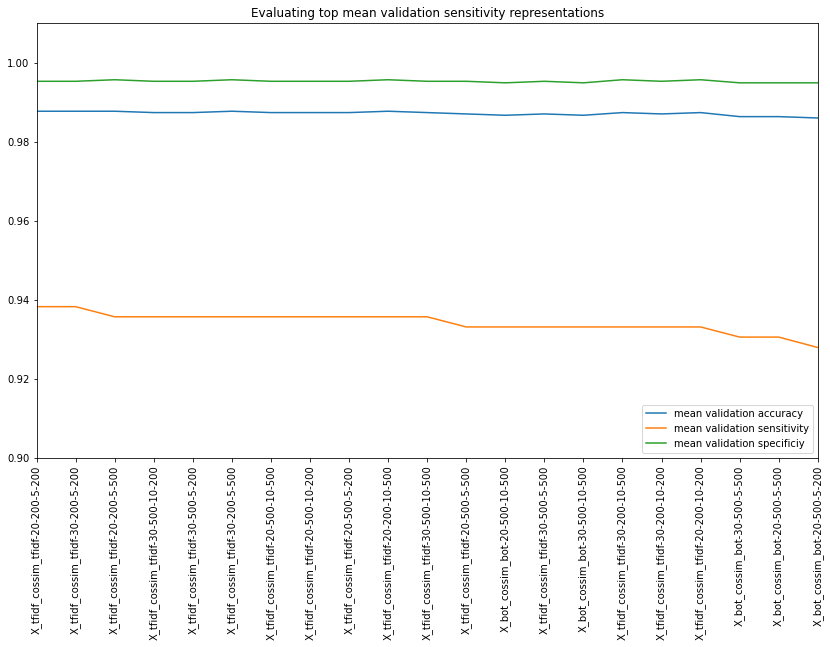

In [39]:
plot_topscores(top_tpr)

---